#### THIS PROGRAM LOADS UP THE H SURFACE DATA (generated with Hasigma5.f) AND PLOTS IT.
#### It can alse be used to compare the model with numerical integrations of the exact equations of motion.

In [1]:
# General libraries used:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from math import *
import scipy as sc
import os
import sys
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output
from ipywidgets import IntProgress
from IPython.display import display
from ipywidgets import VBox
#from ipyvolume import *
#import ipyvolume as ipv # https://ipyvolume.readthedocs.io/en/latest/install.html
from matplotlib import cm
from matplotlib import ticker 
import rebound
import time

# Custom libraries
from H_surface import *
from H_surface_utilities import *
from reboundWrapper import *


# Some general setup for plots:
#mpl.rcParams['axes.titlesize'] = 22AllData
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 17
mpl.rcParams['ytick.labelsize'] = 17
mpl.rcParams['legend.fontsize'] = 20
# mpl.rcParams['lines.linewidth'] = 11
# mpl.rcParams['lines.markersize'] = 11


# Real cases:
# HD31527/cd   AM=0.8795   16:3  -> Buen ejemplo al borde de un ACR.
# GJ876/bc     AM=0.9929    2:1  -> Parece estar en el centro de un ACR muy chiquito al borde de la sup. H.
# GJ876/ce     AM=0.9995    2:1  -> Sup. H muy chica.
# HD73526/bc   AM=0.9587    2:1  -> Ej. perfecto de deep MMR.
# HD181433/cd  AM=0.9156    7:1  -> Esta en reso unos 60 kyrs, luego se sale.
# K278/bc      AM=0.7474    5:3  -> No esta en esta MMR. Hay encuentro.
# K278/bc      AM=0.7475   12:7  -> No esta en esta MMR. Hay encuentro luego de mucho tiempo.
# K278/bc      AM=0.7475   17:10 -> No esta en esta MMR. Hay encuentro.
# GJ3512/bc    AM=0.9454    8:1  -> No esta en MMR. Hay evo secular pura estable.
# HIP57050/bc  AM=0.9342   13:1  -> (~GJ1148) No esta en MMR. Hay evo secular pura estable.
# NNSer/cd     AM=0.       15:7  -> (~GJ1148)
# HD147873/bc  AM=0.9762   17:4  -> No esta en MMR. Hay evo secular pura estable.
# HD128311/bc  AM=0.9806    2:1  -> Ejemplo similar al HD73526/bc pero con amplitud no nula de libración.
# HD183263/bc  AM=0.9837   15:2  -> Dio como 30 sigmas, hay un mucho ruido en la sup H en esa zona :(
# K2-146/bc    AM=0.9884    3:2  -> Esta en MMR y ademas muy cerca de un ACR.
# K2-19/bc     AM=0.9792    3:2  -> Esta en MMR y es un ejemplo de un ACR con centro de lib circulando.

print('Cell 1 executed successfully!')


Cell 1 executed successfully!


In [2]:
# IMPORTANT PARAMETER DEFINITIONS:

# K2:K1 resonance?
K2 = 2
K1 = 1

# Study particular case?
PARTICULAR = True

# DATA FOR GENERAL CASE (Ignore if PARTICULAR = True):
if (not PARTICULAR):
    # String "K2-K1"
    RESO = str(K2) + '-' + str(K1) 
    # Mass and/or e1,e2 case?
    #CASO = "/m12=20/e12=.4.4/"
    M21_str = "1.00" #"m21=20.00"
    M21 = float(M21_str)
    if M21>=1:
        M21 = int(M21)
    # Normalized angular momentum (between 0 and 1 with 4 decimals)
    AM_str = "0.90"
    AM = float(AM_str)
    AM_norm = AM
    # Summarize case in CASO
    CASO = RESO + "/m21=" + str(M21) + "/AM=" + AM_str + "/"
    print('H surface case: ',CASO)


# DIRECTORIES and FILES:
# Common directory root (in Windows use inverted double slash "\\"; in Linux use single slash "/"):
COMUN = "/home/jpons/Desktop/"

# H surface data directory adn filenames:
if (PARTICULAR):
    # Choose the particular system:
    sistema = "HD73526/bc"
    AM_par  = "0.9587"
    # ----------------------------
    dir_H = COMUN + "CondaEnv/CODIGOS/Hamiltoniano/Hasigma_planetario/PARTICULARES/" + sistema + "/" #+ RESO + "/"
    file_H1 = "HSUP1_middle_RHtol=0.00_AM=" + AM_par + ".dat"
    file_H2 = "HSUP2_middle_RHtol=0.00_AM=" + AM_par + ".dat"
    file_in = 'plares.inp'
else:
    dir_H = COMUN + "CondaEnv/CODIGOS/Hamiltoniano/Hasigma_planetario/COPLANAR/" + CASO
    file_H1 = "HSUP1_MMR" + RESO + "_m21=" + M21_str + "_AM=" + AM_str + ".dat" #"HSUP1_MMR2-1_m21=1.00_AM=0.80.dat"
    file_H2 = "HSUP1_MMR" + RESO + "_m21=" + M21_str + "_AM=" + AM_str + ".dat" #"HSUP1_MMR2-1_m21=1.00_AM=0.80.dat"
    file_in = 'plares_clusteruy.inp'

int_setup = "ints/"
# Graphics directory to save H surface plots:
dir_graf = COMUN + "GRAFICOS/" + sistema
#dir_graf = dir_H + int_setup
# Surface plots filenames:
fileH_graf = "HSUP" 
fileMD_graf = "MDSUP"

# Numerical integration comparisons directories:
dirs_int = ['e2=0.59_dw=180_s1=0',
            'e2=0.52_dw=180_s1=0',
            'e2=0.44_dw=180_s1=0',
            'e2=0.59_dw=-99_s1=110',
            'e2=0.55_dw=-99_s1=121',
            'e2=0.49_dw=-99_s1=126',
            'e2=0.44_dw=-99_s1=127',
            'e2=0.47_dw=60_s1=61',
            'e2=0.44_dw=60_s1=60',
] 

if PARTICULAR: dirs_int = ['e1=0.29_w1=-76_s1=338'] # particular single case

dirs_int = [dir_H + int_setup + caso + "/" for caso in dirs_int] # prepend dir_H

file_data_pla1 = "planet1.dat"
file_data_pla2 = "planet2.dat"


# ***** BOOLEAN FLAGS ***** (...for some setup...):
# General setup:
# If ANGLE_POS = True => The angles: (0, 360). If ANGLE_POS = False => The angles: (-180,180). 
ANGLE_POS = False
# Save plots? (only num int data and normal plots, interactive ones are saved using the widget menu)
GUARDAR = True

# H surface setup:
# Use theta instead of sigma? 
THETA = False
# Plot mindis surface?
MINDIS = False
# Filter according RHtol? (encounter if mindis<RHtol)
RH_tol = 5 #2*sqrt(3)
# Interpolate H surface to increase precision?
INTERPOLAR = True


# NUMERICAL INTEGRATION SETUP:
# Compare with numerical integration loaded from an input file?
COMPARAR = False
# Intregate in this notebook using Rebound?
INTEGRAR = True
# Some aspects of integrations:
# 1) If COMPARE = True, then numerical integrations are uploaded from dirs_int locations
# 2) If INTEGRAR = True, the integration initial conditions are defined depending on the ACR encountered
# in cell 11. See cell 10 for more information.
# 3) All integrations ran with Rebound are saved in dir_H by default. 
# 4) See cells 12 and 13 for numerical integration setup.
# The precision of the integration uploaded when COMPARAR = True can be lowered.
FIL = 1   # FIL is the factor by the precision is lowered. FIL = 1 does not skip any data.
proy = 1   # If want a projection in the interactive plots, set proy = 0, if not, set proy = 1.
fac = 1.0 # Factor that mulitplies a1i (to find a better a1i in case structure law bothers).

# Plots setup:
# H surfaces to plot? (1 = H1 surface, 2= H2 surface, 3 = both surfaces)
SURF = 3
# By default H surface are in black and white, do you want color?
COLOR = False
# Project H surface on plane (e1,dw)?
PROYECTAR = False
# Image quality? (in dpi, 150 is ok)
cal = 150
# Format? ('png', 'jpeg', 'eps', etc)
formato = 'jpeg'
# Surface plots file names:
fileH_graf  = fileH_graf  + "." + formato
fileMD_graf = fileMD_graf + "." + formato


print('Cell 2 executed successfully!')

Cell 2 executed successfully!


[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42]
[0.04 0.09 0.13 0.15 0.17 0.19 0.2  0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38]
[0.38       0.37170732 0.36341463 0.35512195 0.34682927 0.33853659
 0.3302439  0.32195122 0.31365854 0.30536585 0.29707317 0.28878049
 0.2804878  0.27219512 0.26390244 0.25560976 0.24731707 0.23902439
 0.23073171 0.22243902 0.21414634 0.20585366 0.19756098 0.18926829
 0.18097561 0.17268293 0.16439024 0.15609756 0.14780488 0.1395122
 0.13121951 0.12292683 0.11463415 0.10634146 0.09804878 0.0897561
 0.08146341 0.07317073 0.06487805 0.05658537 0.04829268 0.04      ]
42
24
42


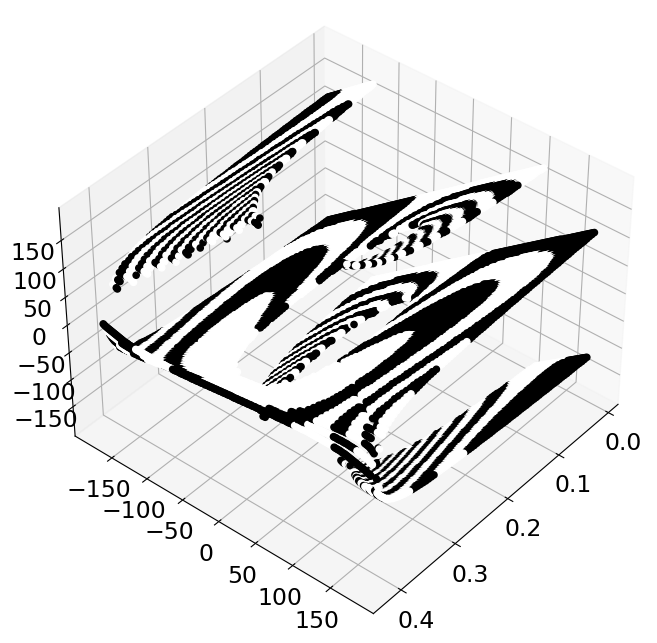

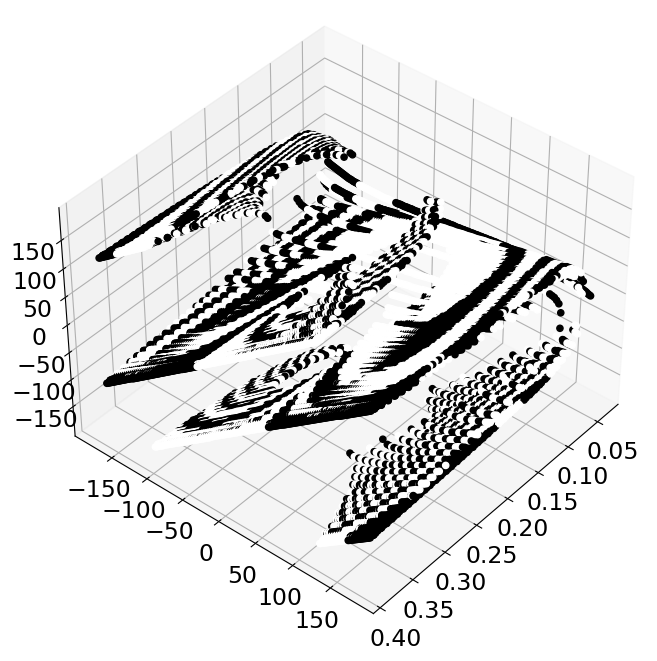

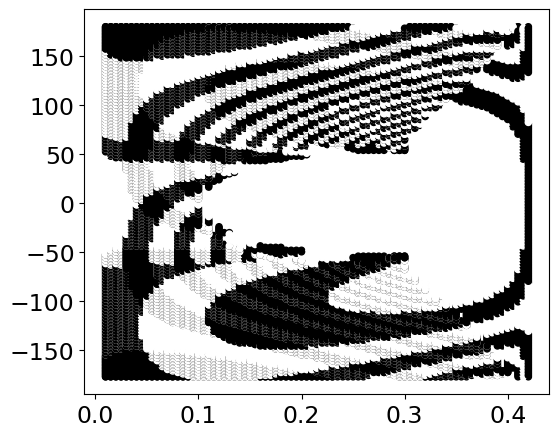

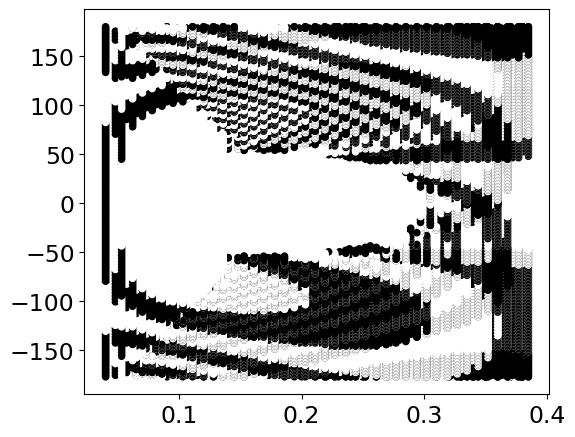

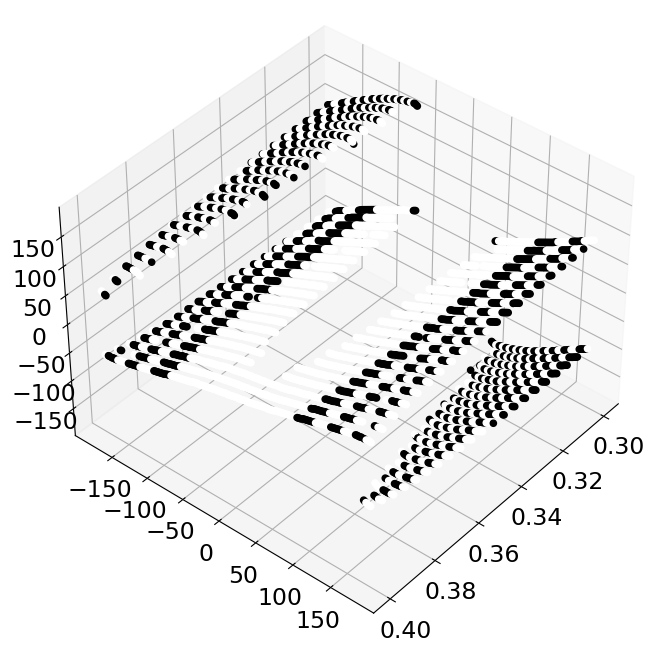

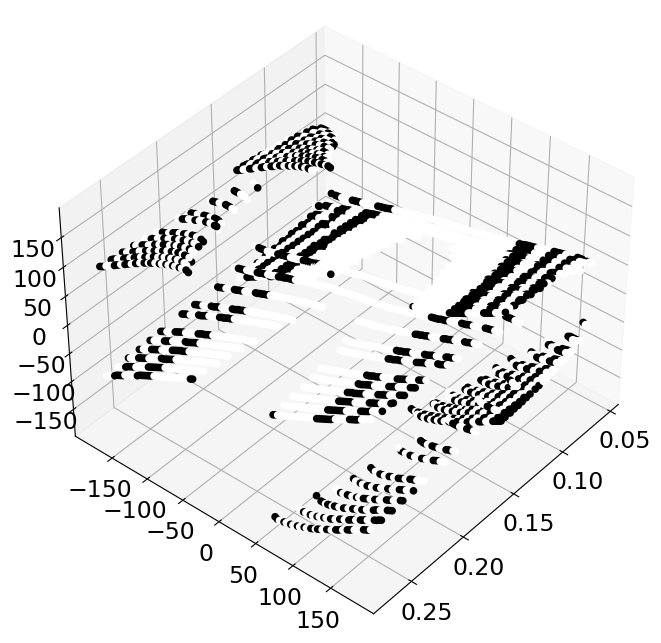

In [3]:

# MAIN

# H surface creation
Hsup = Hsurface(dir_H, file_H1, file_H2, K1, K2, ANGLE_POS, MINDIS, True, RH_tol)

# Interpolate H surface to gain resolution
Hsup.interpolateHdata()

# *** H surface plots: ***
# Colors used:
if COLOR:
    colormap = cm.gist_ncar
    #colormap = cm.flag
else:
    cmapObj = Hcolormap(stack = True, resol = 1, Ncm = 40, Nseg2 = 1, cmap_used = 'gray') # improve names of arguments!!!
    colormap =cmapObj.newcm
    
plotHsurface(Hsup, colormap, pointSize = 20, orientation = [40, 40]) # Pasar de funcion a metodo del objeto Hsurface()!!!

plotHsurface(Hsup, colormap, pointSize = 20, orientation = [40, 40], figSize = (6, 5), project = True) # Projected plot

# Fitler H surface data
Hsup.filterHdata(elimits = [0.3, 0.4])
plotHsurface(Hsup, colormap, pointSize = 20, orientation = [40, 40]) 



INTEGRAR = False
if INTEGRAR:

    # INTEGRATION'S INSTANTIATIONS (definitions)

    # HD73526 system
    t_Tot = 1e4   # total int. time
    d_T   = 0.001 # paso de la int.
    d_out = 1     # output step

    # sigma1 = 338 (thesis)
    integracion1 = Integration2coplanarPlanets(m0=1.014, m1=2.25, m2=2.25, a1i=0.65, e1i=0.29, w1i=-76, M1i=130, a2i=1.03, e2i=0.28, w2i=0, M2i=0, tTot=t_Tot, dT=d_T, dOut=d_out) 
    # sigma1 = 346 (paper, keplerian)
    integracion2 = Integration2coplanarPlanets(m0=1.014, m1=2.25, m2=2.25, a1i=0.65, e1i=0.29, w1i=-76, M1i=138, a2i=1.03, e2i=0.28, w2i=0, M2i=0, tTot=t_Tot, dT=d_T, dOut=d_out)


    # HD31527 system
    t_Tot = 1e5 # total int. time
    d_T   = 0.01 # paso de la int.
    d_out = 1  # output step

    # sigma1 = 318 (thesis)
    integracion3 = Integration2coplanarPlanets(m0=0.96, m1=15.0399/317.907, m2=13.5044/317.907, a1i=0.2664, e1i=0.03, w1i=93.7, M1i=326.27, a2i=0.8121, e2i=0.569, w2i=0, M2i=0, tTot=t_Tot, dT=d_T, dOut=d_out, K1=3, K2=16) 
    # sigma1 = 250 (paper)
    integracion4 = Integration2coplanarPlanets(m0=0.96, m1=15.0399/317.907, m2=13.5044/317.907, a1i=0.2664, e1i=0.03, w1i=93.7, M1i=303.6, a2i=0.8121, e2i=0.569, w2i=0, M2i=0, tTot=t_Tot, dT=d_T, dOut=d_out, K1=3, K2=16) 


    # K2-19 system
    t_Tot = 1e2     # total int. time
    d_T   = 0.00001 # paso de la int.
    d_out = 0.01    # output step

    # sigma1 = 338 (thesis)
    integracion5 = Integration2coplanarPlanets(m0=0.88, m1=32.4/317.907, m2=10.8/317.907, a1i=0.0745, e1i=0.2, w1i=-2.37, M1i=86.56, a2i=0.0977, e2i=0.21, w2i=0, M2i=0, tTot=t_Tot, dT=d_T, dOut=d_out, K1=2, K2=3) 
    # sigma1 = 346 (paper, keplerian)
    integracion6 = Integration2coplanarPlanets(m0=0.88, m1=32.4/317.907, m2=10.8/317.907, a1i=0.0745, e1i=0.2, w1i=-2.37, M1i=57.56, a2i=0.0977, e2i=0.21, w2i=0, M2i=0, tTot=t_Tot, dT=d_T, dOut=d_out, K1=2, K2=3) 


    # INTEGRATION'S RANs

    # Run integration
    #integracion1.startIntegration()
    #integracion1.proccessAngles(ANGLE_POS)
    #integracion1.plotIntegration()

    # Run integration
    #integracion2.startIntegration()
    #integracion2.proccessAngles(ANGLE_POS)
    #integracion2.plotIntegration()

    # Run integration
    integracion3.startIntegration()
    integracion3.proccessAngles(ANGLE_POS)
    print("***** SYSTEM HD31527 - THESIS CASE *****")
    integracion3.plotIntegration(size = (10, 6))
    print("****************************************")

    # Run integration
    integracion4.startIntegration()
    integracion4.proccessAngles(ANGLE_POS)
    print("***** SYSTEM HD31527 - PAPER CASE *****")
    integracion4.plotIntegration(size = (10, 6))
    print("***************************************")
    
    # Run integration
    integracion5.startIntegration()
    integracion5.proccessAngles(ANGLE_POS)
    print("***** SYSTEM K2-19 - THESIS CASE *****")
    integracion5.plotIntegration(size = (10, 6))
    print("***************************************")

    # Run integration
    integracion6.startIntegration()
    integracion6.proccessAngles(ANGLE_POS)
    print("***** SYSTEM K2-19 - PAPER CASE *****")
    integracion6.plotIntegration(size = (10, 6))
    print("*************************************")

    if GUARDAR:
        dir_plot = dir_H + int_setup + caso_int + "/"
        dir_data = dir_plot

        savePlots(dir = dir_plot, filePlot1 = "planet1", filePlot2 = "planet2", filePlot3 = "others")
        saveData(self, dir = dir_data, fileData1 = "planet1.dat", fileData2 = "planet2.dat")


    (10, 8)


   

